In [1]:
include("../LiPoSID.jl")
using LinearAlgebra
using Combinatorics
using Plots
using HDF5

using Dates

Trace distance:

$D(\rho_1, \rho_2) = \frac{1}{2} \operatorname{Tr}|\rho_1 - \rho_2|$,

where $|A| = \sqrt{A^\dagger A}$

Non-Markovianity:

(H.-P. Breuer, E.-M. Laine, J. Piilo, "Measure for the Degree of Non-Markovian Behavior of Quantum Processes in Open Systems," Physical Review Letters, 2009.)

$\sigma = \frac{dD}{dt}$

$ \mathcal{N} = \max_{\rho_1(0), \rho_2(0)}{\int_{\sigma>0}{\sigma dt}} $

In [2]:
function TrDist(ρ₁, ρ₂)
    A = ρ₁-ρ₂
    D = tr(sqrt(A'*A))/2
    if abs(imag(D))>1e-6
        throw(DomainError(D, "Trace distance is complex number"))
    else
        return(real(D))
    end
end    

ρ₁ = [1 im
      -im 0]

ρ₂ = [.99 im
      -im .01]      

TrDist(ρ₁, ρ₂)

0.010000000000000005

In [3]:
function read_timeevolution(file_name, state, γ)
    h5open(file_name, "r") do file
        ρᵧ = read(file[state][string(γ)])
        t = ρᵧ["t"]
        ρ₀₀ = ρᵧ["p0"]; Re_ρ₀₁ = ρᵧ["s_re"];  Im_ρ₀₁ = ρᵧ["s_im"]
        ρ_series = []
        t_series = []

        for i in 1:length(t)
            ρᵢ= [ ρ₀₀[i]                      Re_ρ₀₁[i] + im * Im_ρ₀₁[i]
                  Re_ρ₀₁[i] - im * Im_ρ₀₁[i]  1 - ρ₀₀[i]                 ]
            push!(ρ_series, convert(Matrix{ComplexF64}, ρᵢ))
            push!(t_series, convert(Float64, t[i]))
        end
        return(t_series, ρ_series)
    end
end

function NonMarkovianity(γᵢ, states)
    N=[]
    for (i,j)  in combinations(1:length(states), 2)
        t₁, ρs₁  = read_timeevolution(evol_data_file_name, states[i], γᵢ)
        t₂, ρs₂  = read_timeevolution(evol_data_file_name, states[j], γᵢ)
        dD = diff([TrDist(ρ₁, ρ₂) for (ρ₁, ρ₂) in zip(ρs₁, ρs₂)])
        append!(N,sum(dD[dD.>0]))
    end
    maximum(N)
end    

NonMarkovianity (generic function with 1 method)

In [4]:
γ = [ "0.079477",  "0.25133", "0.79477", "2.5133", "7.9477", "25.133", "79.477", "251.33"]

dodeca_10states = ["D"*string(n) for n=1:10];
basis_states = ["B"*string(n) for n=1:4];

all_files = vcat(basis_states, dodeca_10states);

evol_data_file_name = "../DATA/ALL_GAMMAS_B4_D10.h5"

date_and_time_string =  string(Dates.format(now(), "yyyy-u-dd_at_HH-MM"))

"2024-Mar-15_at_19-44"

In [5]:
NB = [NonMarkovianity(γᵢ, basis_states) for γᵢ in γ]

ND10 = [NonMarkovianity(γᵢ, dodeca_10states) for γᵢ in γ]

Nworst = max.(NB, ND10)


h5open("NonMarkovianityB4D10.h5", "w") do file
    # Write the array to the file under the name "myarray"
    write(file, "NB", NB)
    write(file, "ND10", ND10)
    write(file, "Nworst", Nworst)

end

    

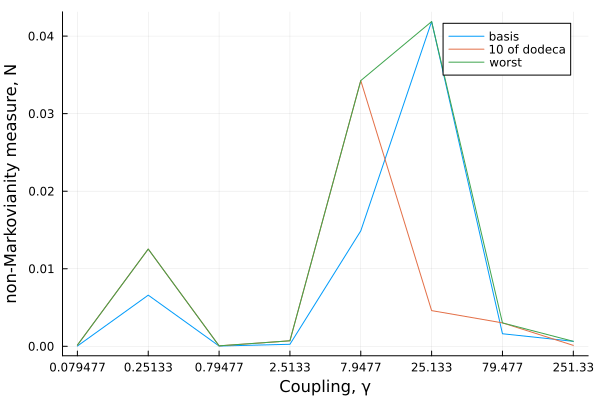

In [12]:
plot(NB, xticks = (1:length(γ), γ), label = "basis")
plot!(ND10, xticks = (1:length(γ), γ), label = "10 of dodeca")
plot!(Nworst, xticks = (1:length(γ), γ), label = "worst")
#title!("Breuer Non-Markovianity Measure")
xlabel!("Coupling, γ")
ylabel!("non-Markovianity measure, N")
#savefig("NonMarkovianity.png")

0.0

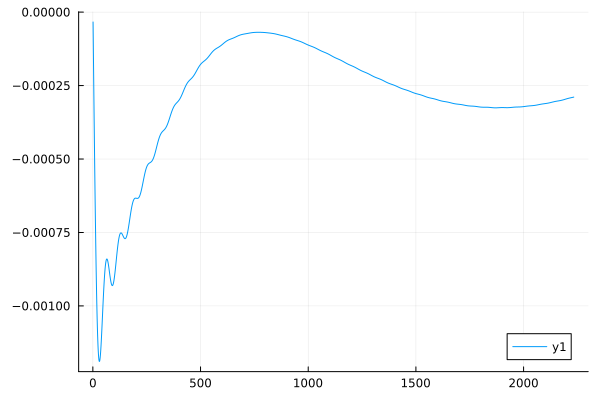

In [10]:
t₁, ρs₁  = read_timeevolution(evol_data_file_name, dodeca_10states[1], "25.133")
t₂, ρs₂  = read_timeevolution(evol_data_file_name, dodeca_10states[9], "25.133")
dD = diff([TrDist(ρ₁, ρ₂) for (ρ₁, ρ₂) in zip(ρs₁, ρs₂)])
print(sum(dD[dD.>0]))
plot(dD)